# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデル・3期間モデルと数値計算の概観

## 2.6.2 射影法

### パラメータの設定はこれまでと同じ

In [2]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    
    # 要素価格
    rent::Float64 #純利子率
    
    # グリッド
    nw::Int64 #所得グリッドの数
    w_max::Float64 #所得グリッドの最大値
    w_min::Float64 #所得グリッドの最小値
    grid_w::Vector{Float64} #所得グリッド
end

In [3]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

In [5]:
params = Calibration();

---

## 新しいパッケージを追加
* 係数を探すために必要になる

In [ ]:
# インストール済みならここはスキップ
#using Pkg
#Pkg.add("LeastSquaresOptim")

In [4]:
# 今回必要なパッケージを読み込む
using Plots
pyplot()
using LeastSquaresOptim # 射影法用の最適化パッケージ

---

## 経済学でよく使う関数を設定しておく
* 限界効用
$$
    u'(c) = c^{-\gamma}
$$

In [6]:
function mu_CRRA(cons, γ)
    return cons^(-γ)
end

mu_CRRA (generic function with 1 method)

---

## 多項式近似をした貯蓄関数
* (2.9)式を関数化
$$
    \hat{g}(w; \theta) = \sum_{n=2}^{N} \theta_{n} w^{n}
$$
* 以下では$N=1$で説明
* 政策関数は$a = \theta_{0} + \theta_{1} w$

In [17]:
# 多項式の係数を一つ定める
θ = [0.0, 1.0]

2-element Vector{Float64}:
 0.0
 1.0

In [29]:
# 選点法(collocation method)の評価点：これまでと同じグリッド
colloc = params.grid_w

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.8999999999999999
 1.0

In [30]:
# 多項式の最大次数
dim_app = length(coef) - 1

# collocation上の多項式：w^{i}
poly = zeros(params.nw, dim_app+1)
for i = 0:dim_app
    poly[:, i+1] = colloc.^i
end

10×2 Matrix{Float64}:
 1.0  0.1
 1.0  0.2
 1.0  0.3
 1.0  0.4
 1.0  0.5
 1.0  0.6
 1.0  0.7
 1.0  0.8
 1.0  0.9
 1.0  1.0

In [32]:
# (2.9)式は\thetaと多項式の値の積
# 各wに対応したaの値
next_a = poly*coef

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.8999999999999999
 1.0

### 多項式の係数(\theta)を一つ与えた際にw上のaを返す関数

In [36]:
"""
政策関数を多項式によって近似する

### インプット
`coef::Vector{Float64}`: 多項式の係数
`eval::Vector:選点

### アウトプット
`next_a::Vector{Float64}`:2期における資産水準(それぞれの選点上)
"""
function approx_policy(coef::Vector{Float64}, colloc::Vector{Float64})
    dim_app = length(coef) - 1
    nw = length(colloc) # paramsを引数としていないのでnwを関数内で確認
    poly = zeros(nw, dim_app+1)
    for i = 0:dim_app
        poly[:, i+1] = colloc.^i
    end 
    next_a = poly*coef
    return next_a
end

approx_policy

---

## (2.9)式の政策関数に基づいて残差を計算する

In [37]:
# ⬆で作成した関数を使って係数\thetaの下でのaを計算
a = approx_policy(θ, params.grid_w)

10-element Vector{Float64}:
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.8999999999999999
 1.0

In [38]:
# 近似したaを使って、2各wにおける1期の消費水準を計算
c1 = params.grid_w - a

# 近似したaを使って、2期の消費水準を計算
c2 = (1.0 + params.rent)*a

10-element Vector{Float64}:
 0.2097567579081786
 0.4195135158163572
 0.6292702737245357
 0.8390270316327144
 1.048783789540893
 1.2585405474490714
 1.46829730535725
 1.6780540632654288
 1.887810821173607
 2.097567579081786

In [40]:
mu1 = zeros(params.nw) #1期における限界効用
mu2 = similar(mu1) #2期における限界効用
resid = similar(mu1) #残差

for i = 1:params.nw
    if c1[i] > 0.0
        mu1[i] = mu_CRRA(c1[i], params.γ)
    else
        mu1[i] = 10000.0 # 負の消費に対するペナルティ
    end

    if c2[i] > 0.0
        mu2[i] = mu_CRRA(c2[i], params.γ)
    else
        mu2[i] = 10000.0 # 負の消費に対するペナルティ
    end

    # 比を取って残差を導出
    resid[i] = params.β*(1.0 + params.rent)*(mu2[i]/mu1[i]) - 1.0
end

10-element Vector{Float64}:
 -0.9969705000255128
 -0.9992426250063782
 -0.9996633888917237
 -0.9998106562515946
 -0.9998788200010205
 -0.9999158472229309
 -0.9999381734699084
 -0.9999526640628986
 -0.9999625987657471
 -0.9999697050002552

In [45]:
"""
選点に基づいてオイラー方程式の残差を返す

### インプット
`coef::Vector{Float64}`:多項式の係数
`m::Models`:パラメータを含む構造体

### アウトプット
`residual::Vector`:残差
"""
function resid_projection(coef::Vector{Float64}, params::Models)

    a = approx_policy(coef, params.grid_w)

    c1 = params.grid_w - a
    c2 = (1.0 + params.rent)*a

    mu1 = zeros(params.nw)
    mu2 = similar(mu1)
    resid = similar(mu1)

    for i = 1:params.nw
        if c1[i] > 0.0
            mu1[i] = mu_CRRA(c1[i], params.γ)
        else
            mu1[i] = 10000.0
        end

        if c2[i] > 0.0
            mu2[i] = mu_CRRA(c2[i], params.γ)
        else
            mu2[i] = 10000.0
        end
        resid[i] = params.β*(1.0 + params.rent)*(mu2[i]/mu1[i]) - 1.0
    end

    return resid
end

resid_projection

---

## 選点上で残差がゼロになるような\thetaを探す

In [42]:
# 一変数の関数に変換
resid_projection!(θ) = resid_projection(θ, params)

resid_projection! (generic function with 1 method)

In [46]:
# レーベンバーグ・マルカート法で非線形最小二乗法を行う
# LeastSquaresOptim.jl パッケージを利用：QuantEcon参照

θ_init = [0.1, 0.35] # 初期値を適当に与える
res = LeastSquaresOptim.optimize(resid_projection!, θ_init, LevenbergMarquardt())

Results of Optimization Algorithm
 * Algorithm: LevenbergMarquardt
 * Minimizer: [1.0133053578581011e-12,0.3550088777075531]
 * Sum of squares at Minimum: 0.000000
 * Iterations: 11
 * Convergence: true
 * |x - x'| < 1.0e-08: true
 * |f(x) - f(x')| / |f(x)| < 1.0e-08: false
 * |g(x)| < 1.0e-08: false
 * Function Calls: 12
 * Gradient Calls: 9
 * Multiplication Calls: 33


#### ⬆の計算結果の読み方(の一部)を説明
* Algorithm：Levenberg and Marquardt法というアルゴリズムで非線形最小二乗法を行った
* Minimizer：計算結果として得られた\theta
    * 今回の解
* Sum of square at Minimum：最小二乗法なので、誤差の和がいくつかを表示
    * 小数点第6位まで0
* Iterations：何回繰り返し計算をしたか
* |x - x'| < 1.0e-08：\thetaの繰り返し計算誤差が小さいことを確認
* |f(x) - f(x')| / |f(x)| < 1.0e-08：残差の繰り返し計算誤差が小さいかを確認←今回はfalse

In [47]:
# ゼロ点探索によって得た係数を使って政策関数を求める
# resという変数に計算結果一式がすべて入っていて、その中からminimizer(⬆の説明の通り、minimizerは誤差を最小にする\theta)を取り出してくる
next_a = approx_policy(res.minimizer, params.grid_w)

10-element Vector{Float64}:
 0.03550088777176862
 0.07100177554252393
 0.10650266331327923
 0.14200355108403456
 0.17750443885478986
 0.21300532662554517
 0.24850621439630047
 0.2840071021670558
 0.3195079899378111
 0.35500887770856643

In [48]:
"""
射影法によって2期間モデルを解く

# インプット
`m::Models`: パラメータを含む構造体
`coef_init::Vector{Float64}`:係数の初期予想

# アウトプット
`res.minimizer`:非線形最小二乗法によって得られた係数
`res.converged::Bool`:最小二乗法が収束したかを示す変数
`next_a`:射影法によって得られる政策関数
"""
function projection(params::Models, θ_init = [0.1, 0.35])

    resid_projection!(coef) = resid_projection(coef, params)

    res = LeastSquaresOptim.optimize(resid_projection!, θ_init, LevenbergMarquardt())

    next_a = approx_policy(res.minimizer, params.grid_w)

    return res.minimizer, res.converged , next_a
end

projection

In [49]:
@time res = projection(params) #実行時間の計測

  0.305115 seconds (494.44 k allocations: 25.080 MiB, 99.81% compilation time)


([1.0133053578581011e-12, 0.3550088777075531], true, [0.03550088777176862, 0.07100177554252393, 0.10650266331327923, 0.14200355108403456, 0.17750443885478986, 0.21300532662554517, 0.24850621439630047, 0.2840071021670558, 0.3195079899378111, 0.35500887770856643])

---

## 計算結果を出力

In [50]:
# 解析解
# テキストの(2.4)式
coef1 = (params.β*(1.0+params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0+params.rent))
a_cfs = coef2*params.grid_w;

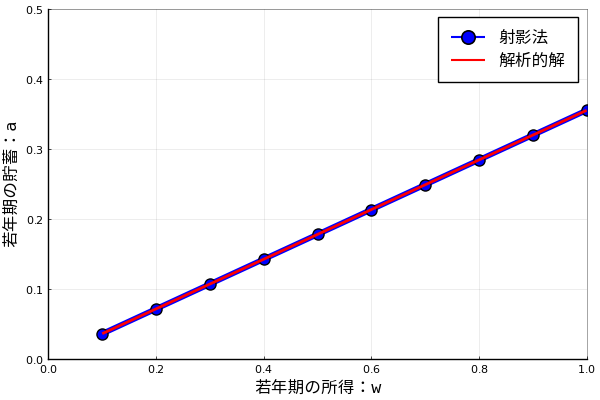

In [51]:
plt = plot(params.grid_w, res[3],
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("射影法"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="解析的解")
#savefig("Fig2_pol_projection_method.pdf")

---

## エクササイズ
* グリッドの数を増やしてみよう
* 政策関数の次数を増やしたら、何がおこるだろうか
* 初期値を変更したら、収束するだろうか。また、その際に計算速度はどのように変わるかを確認してみよう。